# Video classification with a 3D convolutional neural network

# # LIBRARIES



In [7]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import requests
import remotezip as rz

import tensorflow as tf
import keras
from keras import layers

import os
import pafy
import math
import datetime as dt
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


Setting constant value for execution

In [20]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Data Visualization

As the Datas is Scattered in one folder, first We need to classify and store them in different folder according to their class name

In [16]:
import os
import shutil

def organize_videos_by_class(dataset_path, output_path):
    # List all video files in the dataset folder
    video_files = [f for f in os.listdir(dataset_path) if f.endswith('.avi')]

    # Create output folder if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Iterate through each video file
    for video_file in video_files:
        # Extract the class name from the video file name
        class_name = video_file.split('_')[1]  # Assuming the class name is between underscores

        # Create a folder for the class if it doesn't exist
        class_folder = os.path.join(output_path, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Move the video file to the class folder
        video_file_path = os.path.join(dataset_path, video_file)
        shutil.move(video_file_path, os.path.join(class_folder, video_file))

# Specify the path to the dataset folder and the output folder
dataset_path = 'dataset/UCF101'  # Replace with the actual path to your dataset
output_path = 'dataset/UCF101'    # Replace with the desired output path

# Call the function to organize the videos by class
organize_videos_by_class(dataset_path, output_path)

# Data Visualize

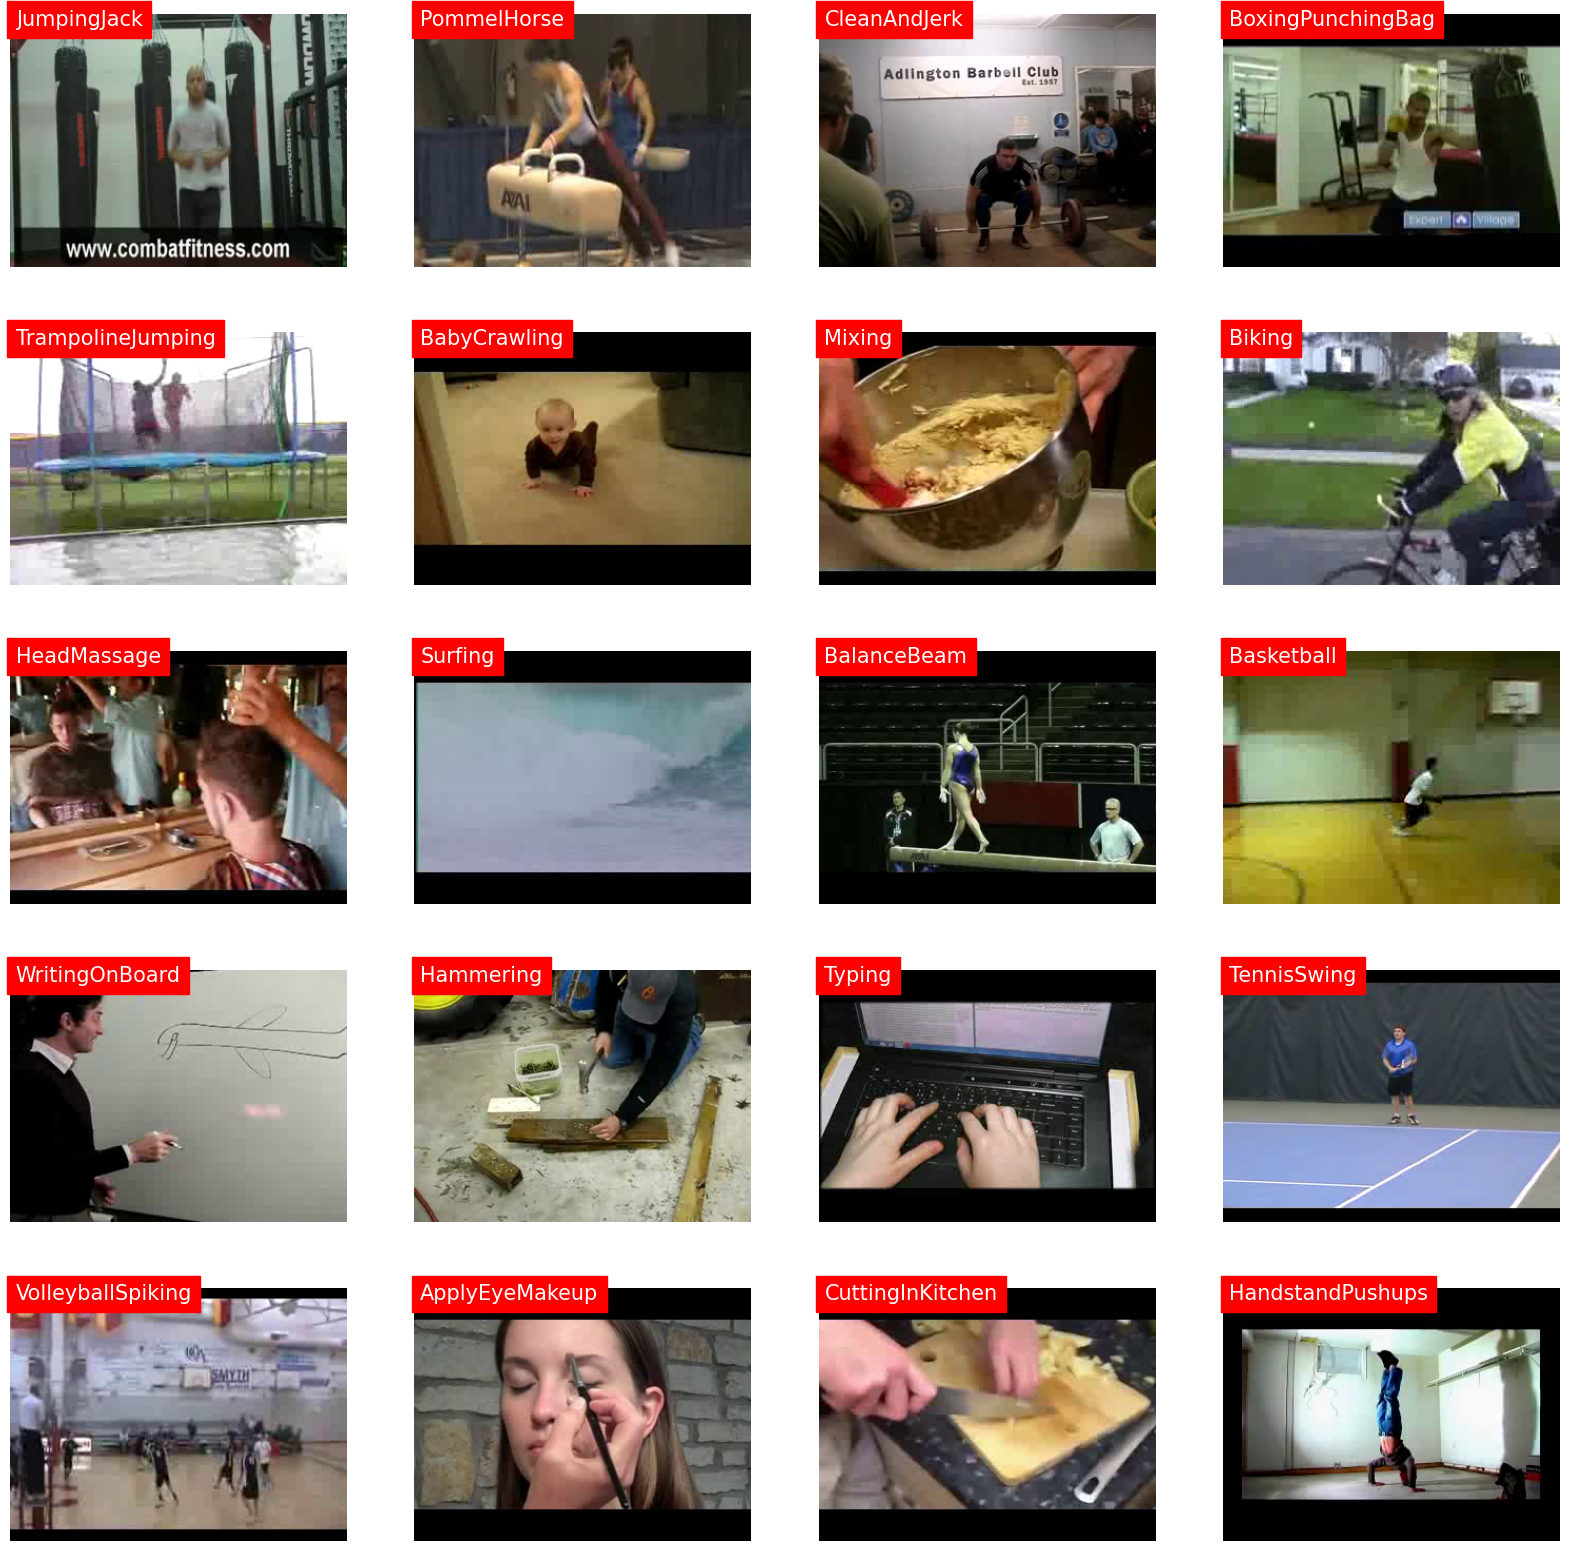

In [9]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('E:/Video Classification With 3DCNN/dataset/UCF101')

# Generate a list of 20 random values. The values will be between 0-100, 
# where 50 is the total number of classes in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'E:/Video Classification With 3DCNN/dataset/UCF101/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'E:/Video Classification With 3DCNN/dataset/UCF101/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Display the frame.
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

    # Write the class name as a label below the image.
    plt.text(5, 5, selected_class_Name, color='white', backgroundcolor='Red', fontsize=15, va='center')

plt.show()

# Data Pre-Processing

In [14]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64 #resizing the image for lowering time assumption

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20 #each video will be divided into 20 frames

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "E:/Video Classification With 3DCNN/dataset/UCF101"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["ApplyLipstick", "TaiChi", "PlayingFlute", "HandstandWalking"]

In [15]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

# Dataset creation converting to numpy and used above cell function

In [16]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [17]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: ApplyLipstick
Extracting Data of Class: TaiChi
Extracting Data of Class: PlayingFlute
Extracting Data of Class: HandstandWalking


Converting labels using one hot encoding

In [18]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

# TRAIN_TEST_SPLIT

In [21]:
# Split into training and temporary set (80% training, 20% temporary)
features_train, features_temp, labels_train, labels_temp = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size=0.2, shuffle=True,
                                                                            random_state=seed_constant)

Adding validation set

In [22]:
# Further split the temporary set into validation and test sets (30% validation, 70% test)
features_val, features_test, labels_val, labels_test = train_test_split(features_temp, labels_temp,
                                                                        test_size=0.7, shuffle=True,
                                                                        random_state=seed_constant)

# Creating_Models

In [36]:
model = Sequential()

model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(CLASSES_LIST), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 64, 64, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 32, 32, 32)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 32, 32, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 5, 16, 16, 64)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 256)             

In [45]:
history = model.fit(features_train, labels_train, epochs=50, batch_size=32, validation_data=(features_val, labels_val),verbose = 1)


Epoch 1/50
12/12 [==============================] - 6s 477ms/step - loss: 0.0373 - accuracy: 0.9974 - val_loss: 1.1505 - val_accuracy: 0.7143
Epoch 2/50
12/12 [==============================] - 6s 472ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 1.6039 - val_accuracy: 0.7857
Epoch 3/50
12/12 [==============================] - 6s 473ms/step - loss: 0.0263 - accuracy: 0.9948 - val_loss: 1.1522 - val_accuracy: 0.8571
Epoch 4/50
12/12 [==============================] - 6s 521ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.4011 - val_accuracy: 0.8214
Epoch 5/50
12/12 [==============================] - 7s 593ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.5447 - val_accuracy: 0.8214
Epoch 6/50
12/12 [==============================] - 7s 587ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.7474 - val_accuracy: 0.8214
Epoch 7/50
12/12 [==============================] - 7s 582ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.7850 - val_accuracy: 0.8571
Epoch 

In [43]:
test_loss, test_accuracy = model.evaluate(features_test, labels_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

3/3 [==============================] - 0s 89ms/step - loss: 0.2586 - accuracy: 0.9559
Test Accuracy: 95.59%


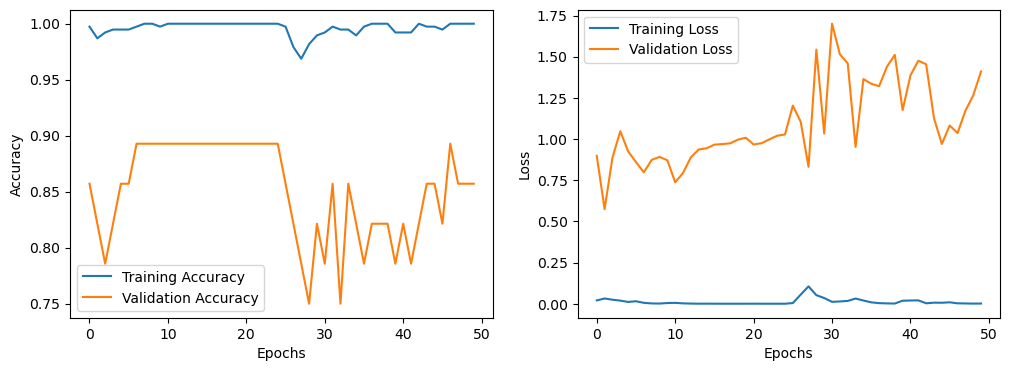

In [44]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

We Can See That the data Is overfitting here

# Trying Different Model

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

# Define the input shape based on your frame dimensions and sequence length
input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output before the dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(len(CLASSES_LIST), activation='softmax'))  # Output layer with softmax activation

# Display the model summary
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_41 (Conv3D)          (None, 18, 62, 62, 32)    2624      
                                                                 
 max_pooling3d_40 (MaxPooli  (None, 9, 31, 31, 32)     0         
 ng3D)                                                           
                                                                 
 conv3d_42 (Conv3D)          (None, 7, 29, 29, 64)     55360     
                                                                 
 max_pooling3d_41 (MaxPooli  (None, 3, 14, 14, 64)     0         
 ng3D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 37632)             0         
                                                                 
 dense_20 (Dense)            (None, 128)             

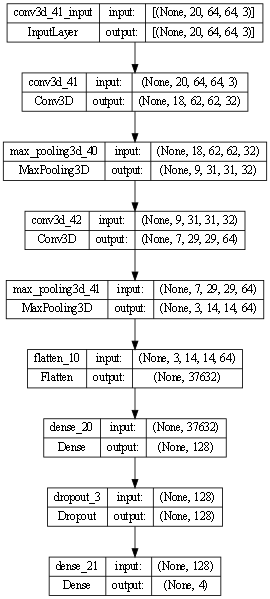

In [67]:
# Visualize the model
from tensorflow.keras.utils import plot_model

plot_model(model, expand_nested=True, dpi=60, show_shapes=True)


In [47]:
# Compile your model before using fit
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set the number of epochs and batch size
epochs = 10
batch_size = 32

# Train the model using the fit function
history = model.fit(
    features_train, labels_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(features_val, labels_val),
    verbose=1
)

Epoch 1/10
12/12 [==============================] - 5s 324ms/step - loss: 1.9135 - accuracy: 0.3594 - val_loss: 1.2679 - val_accuracy: 0.3571
Epoch 2/10
12/12 [==============================] - 4s 315ms/step - loss: 1.0169 - accuracy: 0.5885 - val_loss: 0.6010 - val_accuracy: 0.7500
Epoch 3/10
12/12 [==============================] - 4s 320ms/step - loss: 0.5691 - accuracy: 0.7865 - val_loss: 0.6246 - val_accuracy: 0.7143
Epoch 4/10
12/12 [==============================] - 4s 314ms/step - loss: 0.4371 - accuracy: 0.8516 - val_loss: 0.4288 - val_accuracy: 0.7500
Epoch 5/10
12/12 [==============================] - 4s 311ms/step - loss: 0.3700 - accuracy: 0.8698 - val_loss: 0.4508 - val_accuracy: 0.8214
Epoch 6/10
12/12 [==============================] - 4s 313ms/step - loss: 0.2178 - accuracy: 0.9115 - val_loss: 0.5801 - val_accuracy: 0.7857
Epoch 7/10
12/12 [==============================] - 5s 389ms/step - loss: 0.1870 - accuracy: 0.9557 - val_loss: 0.4323 - val_accuracy: 0.8929
Epoch 

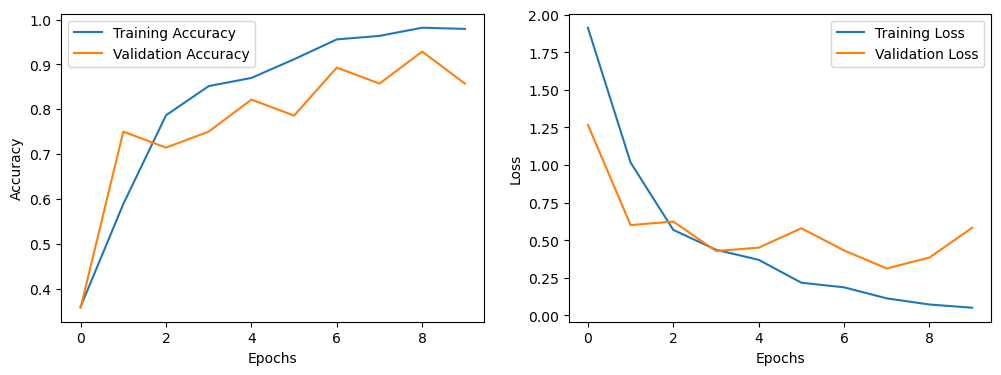

In [49]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Another Model

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Flatten, Dense

# Function to create a 3D CNN model with four convolutional blocks
def create_3d_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # 1st Convolutional Block
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    # 2nd Convolutional Block
    model.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    # 3rd Convolutional Block
    model.add(Conv3D(filters=256, kernel_size=(2, 2, 2), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    # 4th Convolutional Block
    model.add(Conv3D(filters=512, kernel_size=(2, 2, 2), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())

    # Flatten the layers
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Assuming input_shape is (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
num_classes = len(CLASSES_LIST)

# Create the 3D CNN model with four convolutional blocks
model = create_3d_cnn_model(input_shape, num_classes)

# Display the model summary
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_37 (Conv3D)          (None, 20, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 10, 32, 32, 64)    0         
 ng3D)                                                           
                                                                 
 batch_normalization_29 (Ba  (None, 10, 32, 32, 64)    256       
 tchNormalization)                                               
                                                                 
 conv3d_38 (Conv3D)          (None, 10, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_37 (MaxPooli  (None, 5, 16, 16, 128)    0         
 ng3D)                                                           
                                                     

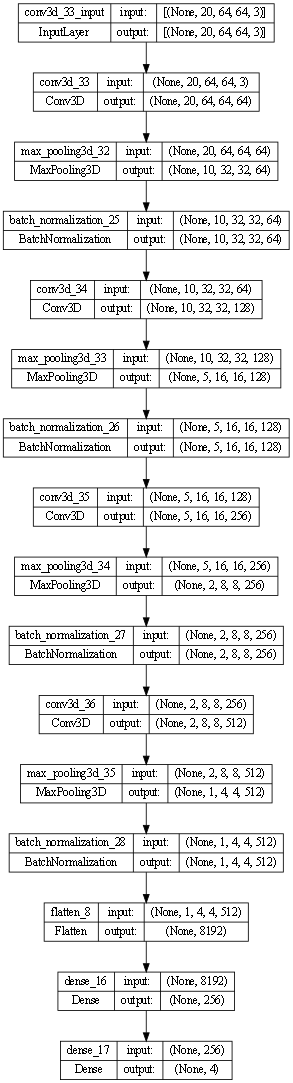

In [64]:
# Visualize the model
from tensorflow.keras.utils import plot_model

plot_model(model, expand_nested=True, dpi=60, show_shapes=True)


In [68]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    features_train, labels_train,
    validation_data=(features_val, labels_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/10
12/12 [==============================] - 4s 329ms/step - loss: 1.5825 - accuracy: 0.3932 - val_loss: 1.1349 - val_accuracy: 0.5714
Epoch 2/10
12/12 [==============================] - 4s 335ms/step - loss: 0.8648 - accuracy: 0.6667 - val_loss: 0.4696 - val_accuracy: 0.8214
Epoch 3/10
12/12 [==============================] - 4s 329ms/step - loss: 0.5427 - accuracy: 0.7865 - val_loss: 0.4422 - val_accuracy: 0.8214
Epoch 4/10
12/12 [==============================] - 4s 326ms/step - loss: 0.3282 - accuracy: 0.8724 - val_loss: 0.3971 - val_accuracy: 0.8214
Epoch 5/10
12/12 [==============================] - 4s 326ms/step - loss: 0.2944 - accuracy: 0.8932 - val_loss: 0.2551 - val_accuracy: 0.8929
Epoch 6/10
12/12 [==============================] - 4s 321ms/step - loss: 0.1447 - accuracy: 0.9531 - val_loss: 0.1817 - val_accuracy: 0.9286
Epoch 7/10
12/12 [==============================] - 5s 409ms/step - loss: 0.0855 - accuracy: 0.9714 - val_loss: 0.1636 - val_accuracy: 0.9643
Epoch 

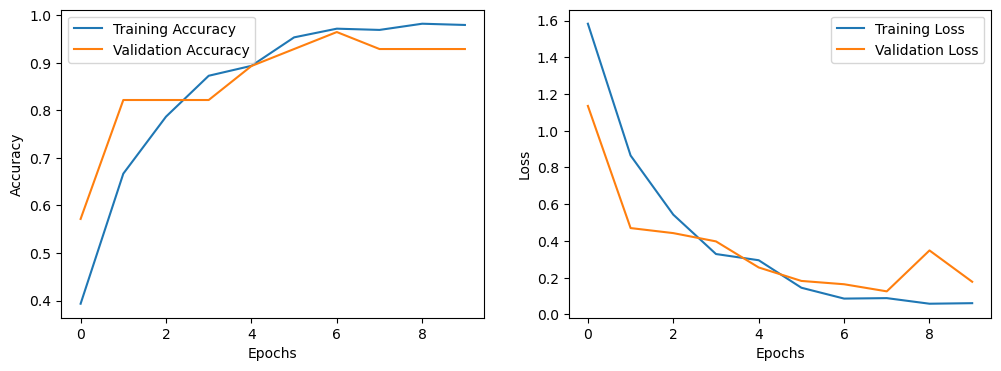

In [69]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()